In [1]:
import numpy as np
import pylab as plt

from emcee import EnsembleSampler

from scipy.interpolate import interp1d as interp
from scipy.optimize import brentq, minimize_scalar
from profiles import build_profile, build_kernel
from dispersion import SphericalJeansDispersion
from likelihood import GaussianLikelihood
#from fitter import *

%matplotlib inline

In [2]:
directory = '/home/andrea/Desktop/work/DWARF/'
rh = 0.04
D = 39.81
theta = 2*rh/D

In [3]:
dm = build_profile('NFW')
st = build_profile('plummer',rh=rh) # Plummer Stellar profile
kr = build_kernel('iso') # isotropic kernel
dwarf_props = {'D':D, 'theta':theta, 'rt':np.inf, 'with_errs':False}
Sigma = SphericalJeansDispersion(dm, st, kr, dwarf_props)

In [4]:
R, v = np.loadtxt(directory+'dsphsim/Ret2_data/dsph_001.txt',usecols=(5, 7),unpack=True)
#R, v = np.load('results/equiRdSphs.npy')
vnan = np.isnan(v)
v = v[~vnan]
R = R[~vnan]
dv = np.zeros_like(v)

In [5]:
LL = GaussianLikelihood([R, v, dv, 0.], Sigma)

In [6]:
LL.set_free('dm_a')
#LL.set_free('dm_b')
LL.set_free('dm_c')
#LL.set_free('dm_r0')

$r_s = 0.35 , \rho_s = 7.55 \times 10^7 , J = 16.72$

In [7]:
LL.free_pars.keys()

['dm_a', 'J', 'dm_c']

In [8]:
def lnprior(theta):
    #r, a, b, c = theta
    #if -3. < r < 2. and 0.5 < a < 3. and 2. < b < 6. and .0 < c < 1.2:
    if -3. < theta < 2.:
        return 0.0
    return -np.inf

def loglike(theta, J):
    #r, a, b, c = theta
    #return LL(a, b, J, 10**r, c)
    return -LL(J, 10**theta)

def lnprob(theta, J):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta, J)

In [22]:
r_arr, L_arr = np.load('Lr_arr.npy')

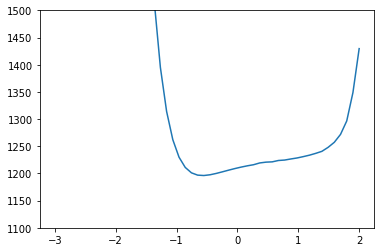

In [23]:
plt.plot(r_arr, L_arr);
plt.ylim(1100, 1500);

In [20]:
samples = np.load('../results/mcmc/samples_J1672_N1000.npy')
lnprobs = np.load('../results/mcmc/lnprobs_J1672_N1000.npy')

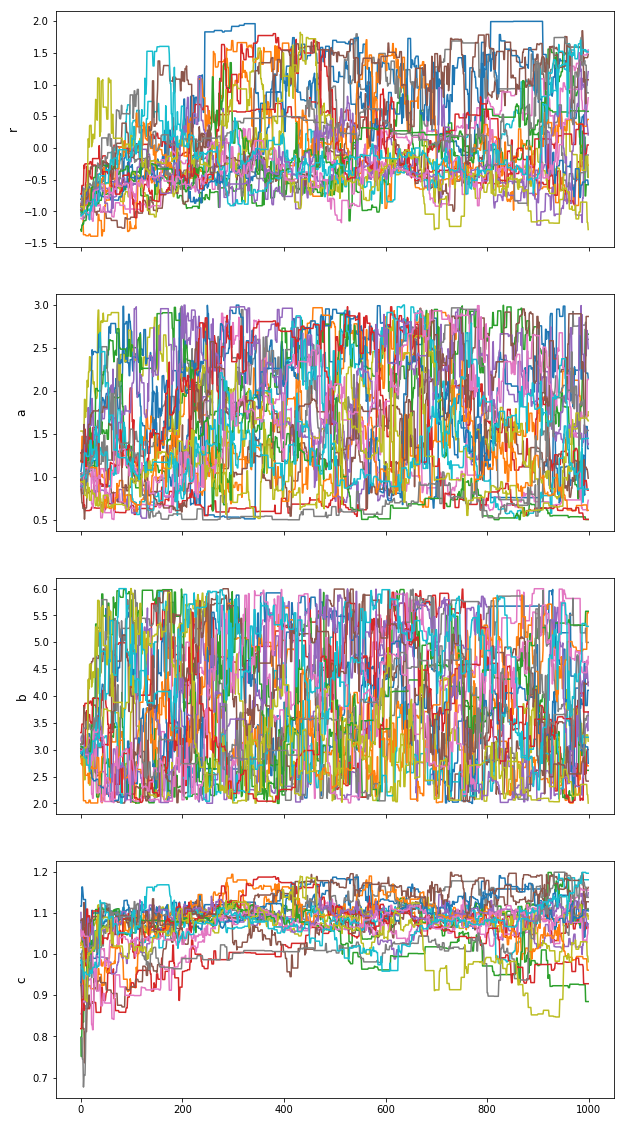

In [22]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,20))
steps = range(len(samples[0]))
for p,(par,ax) in enumerate(zip(['r', 'a', 'b', 'c'],axes)):
    for nw in range(len(samples)):
        vals = [samples[nw][i][p] for i in steps]
        ax.plot(steps, vals)
        ax.set_ylabel(par, fontsize=12);
#plt.savefig('../results/mcmc/chains_J1672_N10000.png', dpi=300)

In [27]:
pltsamples = samples[:, :, :].reshape((-1, len(samples[0][0])))

In [28]:
L = -lnprobs.reshape(-1)
Lmin = min(L)
indLmin = np.where( L==Lmin )[0][-1]
for p,par in enumerate(['r', 'a', 'b', 'c']):
    exec( "{} = np.asarray([pltsamples[i][p] for i in range(len(pltsamples))])".format(par) )
    exec( '{0}_min = {0}[indLmin]'.format(par) )

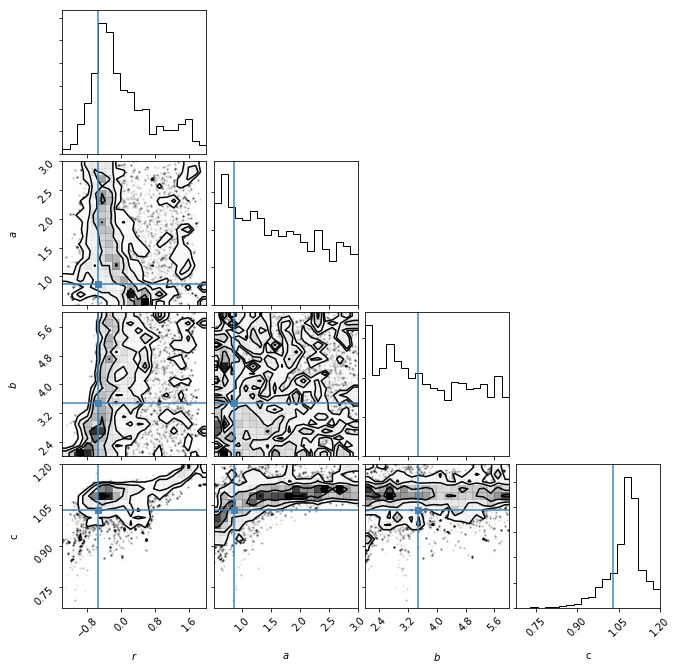

In [29]:
import corner
truep = [-0.55, 0.86, 3.47, 1.03]
minp = [r_min, a_min, b_min, c_min]
fig = corner.corner(pltsamples, labels=["$r$", "$a$", "$b$", "c"], truths=truep)
#plt.savefig('../results/mcmc/corner_J1672_N10000.png', dpi=300)

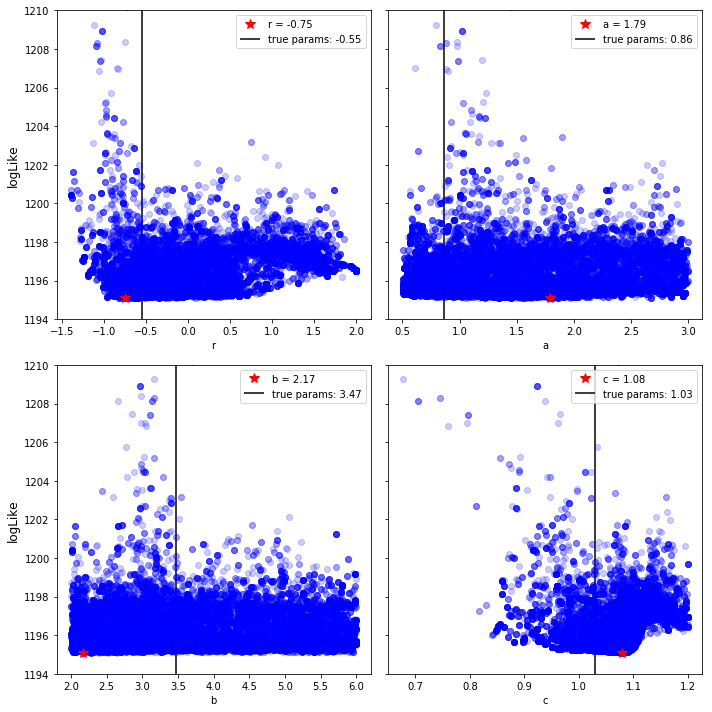

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharey=True)
for i,(par, ax) in enumerate(zip(['r', 'a', 'b', 'c'], axes.flat)):
    ax.plot( eval('{}'.format(par)), L, 'bo', alpha=0.2  );
    exec( 'parmin = {}_min'.format(par) )
    ax.plot( parmin, Lmin, 'r*', ms=10, label= '%s = %.2f'%(par, parmin) );
    ax.vlines(x=truep[i], ymin=0, ymax=2000, label='true params: %.2f'%truep[i]);
    ax.set_xlabel(par);
    if i%2 == 0: 
        ax.set_ylabel('logLike', fontsize=12)
    ax.set_ylim(1194, 1210);
    ax.legend(numpoints=1, loc='upper right');
plt.tight_layout()
#plt.suptitle('J = 16 , 10000 points', fontsize=14);
#plt.savefig('../results/mcmc/Like_params_J1672_N10000.png', dpi=300);

In [32]:
from pymc import gelman_rubin

for par,R in zip(['r', 'a', 'b', 'c'], gelman_rubin(samples)):
    print par, round(R,3)

r 1.186
a 1.205
b 1.103
c 1.17
